# Spam Message Detection Using Fine-Tuned DistilBERT Models: A Comparative Study

## Section 1 — Objective
This notebook investigates the task of **SMS spam detection** using the UCI SMS Spam Collection dataset.
The goal is to compare a **traditional baseline model** (TF-IDF + Logistic Regression) against a **BERT-style transformer model** (DistilBERT) fine-tuned for binary text classification (spam vs ham).

**Research Objective:**  
Evaluate whether fine-tuning a transformer-based language model improves classification performance (Accuracy, Precision, Recall, F1-score) compared to a classical machine learning baseline under a computationally efficient setup (free Google Colab).



**Planned Method (Overview):**
1. Load and explore the dataset (EDA).
2. Create a **stratified subset (n=2000)** to reduce training time while preserving class distribution.
3. Train a baseline TF-IDF + Logistic Regression model.
4. Fine-tune a DistilBERT sequence classification model.
5. Evaluate both models using Accuracy, Precision, Recall, F1-score, and confusion matrices.

## Section 2 — Dataset Description

The dataset used in this study is the **SMS Spam Collection** from the UCI Machine Learning Repository.
It consists of SMS messages labelled as either **spam** or **ham** (non-spam).

- **Total messages:** 5,572  
- **Classes:**  
  - Ham (non-spam)  
  - Spam  

This dataset is widely used in text classification research and is well suited for evaluating
both traditional machine learning models and transformer-based language models.

In [5]:
!pip install --upgrade transformers

In [6]:
# Core libraries
import numpy as np
import pandas as pd
import random

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning (baseline)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Deep learning (BERT-style model)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)
from torch.optim import AdamW

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Check device (CPU / GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import requests

Using device: cuda


In [7]:
import zipfile
import io

zip_url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
response = requests.get(zip_url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("SMSSpamCollection") as f:
        df = pd.read_csv(f, sep="\t", header=None, names=["label", "message"])
        print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df["label"].value_counts())

df.head()

Dataset shape: (5572, 2)

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Section 4 — Data Handling and Stratified Subset

This section prepares the dataset for modelling:
- Encodes labels (ham=0, spam=1)
- Creates a **stratified subset (n=2000)** to reduce training time while preserving the original class distribution.


In [8]:
# Encode labels: ham -> 0, spam -> 1
df["label_id"] = df["label"].map({"ham": 0, "spam": 1})

# Create a stratified subset of size 2000 (preserve class distribution)
subset_size = 2000
df_subset, _ = train_test_split(
    df,
    train_size=subset_size,
    stratify=df["label_id"],
    random_state=SEED
)

print("Subset shape:", df_subset.shape)
print("\nSubset class distribution:")
print(df_subset["label"].value_counts())

# Show a few rows
df_subset[["label", "message"]].head()

Subset shape: (2000, 3)

Subset class distribution:
label
ham     1732
spam     268
Name: count, dtype: int64


,label,message
180,ham,Hi! You just spoke to MANEESHA V. We'd like to...
3192,spam,UR awarded a City Break and could WIN a £200 S...
59,ham,Yes..gauti and sehwag out of odi series.
1722,ham,Am watching house – very entertaining – am get...
189,ham,Have you got Xmas radio times. If not i will g...


## Section 5 — Exploratory Data Analysis (EDA) and Visualisation

This section explores basic characteristics of the SMS messages, including
class distribution and message length. These visualisations help justify
later modelling choices such as class imbalance handling and maximum
sequence length for tokenisation.

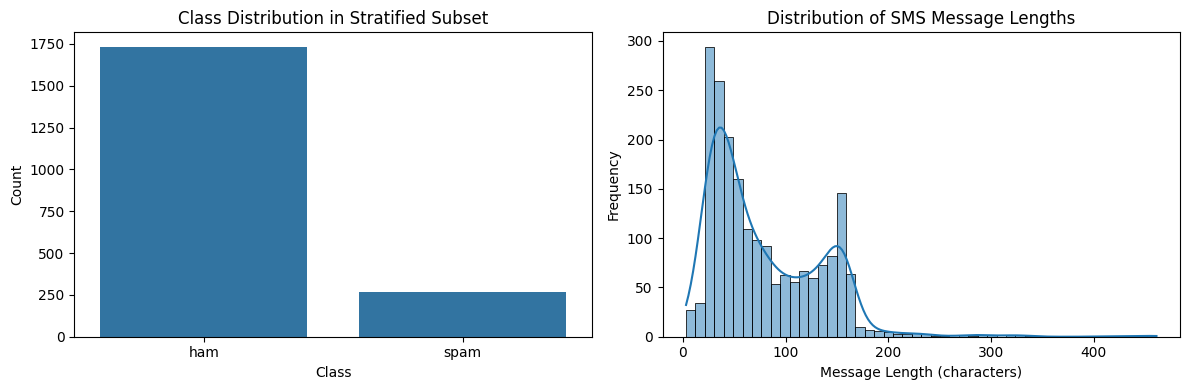

,message_length
count,2000.000000
mean,78.833000
std,55.308784
min,3.000000
25%,36.000000
50%,59.000000
75%,120.000000
max,461.000000


In [9]:
# Add message length feature
df_subset["message_length"] = df_subset["message"].apply(len)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot class distribution
sns.countplot(data=df_subset, x="label", ax=axes[0])
axes[0].set_title("Class Distribution in Stratified Subset")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Plot message length distribution
sns.histplot(df_subset["message_length"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of SMS Message Lengths")
axes[1].set_xlabel("Message Length (characters)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print basic length statistics
df_subset["message_length"].describe()

## Section 6 — Data Preprocessing

This section applies **minimal text preprocessing** to the SMS messages.
Aggressive cleaning techniques such as stopword removal and stemming are
intentionally avoided, as transformer-based models like BERT are designed
to operate effectively on raw text and preserve contextual information.


In [10]:
import re

def clean_text(text):
    """
    Apply minimal text cleaning:
    - Convert to lowercase
    - Remove URLs
    - Remove extra whitespace
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df_subset["clean_message"] = df_subset["message"].apply(clean_text)

# Show original vs cleaned examples
df_subset[["message", "clean_message"]].head()

,message,clean_message
180,Hi! You just spoke to MANEESHA V. We'd like to...,hi! you just spoke to maneesha v. we'd like to...
3192,UR awarded a City Break and could WIN a £200 S...,ur awarded a city break and could win a £200 s...
59,Yes..gauti and sehwag out of odi series.,yes..gauti and sehwag out of odi series.
1722,Am watching house – very entertaining – am get...,am watching house – very entertaining – am get...
189,Have you got Xmas radio times. If not i will g...,have you got xmas radio times. if not i will g...


## Section 7 — Train, Validation, and Test Split

The dataset is split into training, validation, and test sets using a
**stratified strategy** to preserve class distribution across all splits.
This ensures a fair and reliable evaluation of model performance.

In [11]:
# First split: train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    df_subset,
    test_size=0.2,
    stratify=df_subset["label_id"],
    random_state=SEED
)

# Second split: validation (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_id"],
    random_state=SEED
)

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)

print("\nTrain class distribution:")
print(train_df["label"].value_counts())

print("\nValidation class distribution:")
print(val_df["label"].value_counts())

print("\nTest class distribution:")
print(test_df["label"].value_counts())

Train size: (1600, 5)
Validation size: (200, 5)
Test size: (200, 5)

Train class distribution:
label
ham     1386
spam     214
Name: count, dtype: int64

Validation class distribution:
label
ham     173
spam     27
Name: count, dtype: int64

Test class distribution:
label
ham     173
spam     27
Name: count, dtype: int64


## Section 8 — Baseline Model: TF-IDF + Logistic Regression

As a baseline, a traditional machine learning approach is implemented using
TF-IDF feature representation and Logistic Regression. This provides a strong
and interpretable benchmark for evaluating the performance of the
transformer-based model.

In [12]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(train_df["clean_message"])
X_val_tfidf = tfidf.transform(val_df["clean_message"])
X_test_tfidf = tfidf.transform(test_df["clean_message"])

# Logistic Regression baseline with class weights
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=SEED
)

baseline_model.fit(X_train_tfidf, train_df["label_id"])

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [13]:
# Baseline predictions
y_test_true = test_df["label_id"]
y_test_pred = baseline_model.predict(X_test_tfidf)

# Evaluation metrics
baseline_accuracy = accuracy_score(y_test_true, y_test_pred)
baseline_precision = precision_score(y_test_true, y_test_pred)
baseline_recall = recall_score(y_test_true, y_test_pred)
baseline_f1 = f1_score(y_test_true, y_test_pred)

print("Baseline Model Performance:")
print(f"Accuracy : {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall   : {baseline_recall:.4f}")
print(f"F1-score : {baseline_f1:.4f}")

# Confusion matrix
cm_baseline = confusion_matrix(y_test_true, y_test_pred)
print("\nConfusion Matrix:")
print(cm_baseline)

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=["ham", "spam"]))

Baseline Model Performance:
Accuracy : 0.9850
Precision: 0.9286
Recall   : 0.9630
F1-score : 0.9455

Confusion Matrix:
[[171   2]
 [  1  26]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       173
        spam       0.93      0.96      0.95        27

    accuracy                           0.98       200
   macro avg       0.96      0.98      0.97       200
weighted avg       0.99      0.98      0.99       200



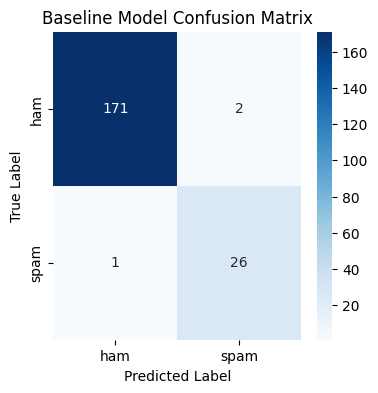

In [14]:
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["ham", "spam"],
    yticklabels=["ham", "spam"]
)
plt.title("Baseline Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Section 9 — Tokenisation Using DistilBERT

In this section, SMS messages are tokenised using the DistilBERT tokenizer.
Tokenisation converts raw text into numerical representations required by
the transformer model, including input IDs and attention masks.
A maximum sequence length of 128 is used, as SMS messages are typically short.

In [15]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

MAX_LENGTH = 128

# Test tokenisation on a sample message
sample_text = train_df["clean_message"].iloc[0]
encoding = tokenizer(
    sample_text,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_tensors="pt"
)

print("Sample text:")
print(sample_text)
print("\nTokenised input IDs shape:", encoding["input_ids"].shape)
print("Attention mask shape:", encoding["attention_mask"].shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Sample text:
you should know now. so how's anthony. are you bringing money. i've school fees to pay and rent and stuff like that. thats why i need your help. a friend in need....|

Tokenised input IDs shape: torch.Size([1, 128])
Attention mask shape: torch.Size([1, 128])


## Section 10 — Dataset and DataLoader Preparation

This section defines a custom PyTorch Dataset class for the tokenised SMS data
and creates DataLoader objects for training, validation, and testing.
This enables efficient batching and iteration during model fine-tuning.

In [16]:
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


# Create Dataset objects
train_dataset = SMSDataset(
    train_df["clean_message"],
    train_df["label_id"],
    tokenizer,
    MAX_LENGTH
)

val_dataset = SMSDataset(
    val_df["clean_message"],
    val_df["label_id"],
    tokenizer,
    MAX_LENGTH
)

test_dataset = SMSDataset(
    test_df["clean_message"],
    test_df["label_id"],
    tokenizer,
    MAX_LENGTH
)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Training samples: 1600
Validation samples: 200
Test samples: 200


In [17]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check one batch
batch = next(iter(train_loader))
print("Batch input_ids shape:", batch["input_ids"].shape)
print("Batch attention_mask shape:", batch["attention_mask"].shape)
print("Batch labels shape:", batch["labels"].shape)

Batch input_ids shape: torch.Size([16, 128])
Batch attention_mask shape: torch.Size([16, 128])
Batch labels shape: torch.Size([16])


## Section 11 — DistilBERT Model Setup and Fine-Tuning

This section initialises a pre-trained DistilBERT model for binary
sequence classification and fine-tunes it on the SMS spam detection task.
Class-weighted loss is used to address class imbalance.

In [18]:
# Load pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

model = model.to(device)

# Compute class weights for imbalance handling
class_counts = train_df["label_id"].value_counts().sort_index()
total_samples = len(train_df)

class_weights = [
    total_samples / class_counts[0],
    total_samples / class_counts[1]
]

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([1.1544, 7.4766], device='cuda:0')


In [19]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [20]:
EPOCHS = 2

def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)


def eval_epoch(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(data_loader), accuracy


# Training loop
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_accuracy = eval_epoch(model, val_loader, loss_fn)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss  : {val_loss:.4f}")
    print(f"Val Acc   : {val_accuracy:.4f}")

Epoch 1/2
Train Loss: 0.1587
Val Loss  : 0.0435
Val Acc   : 0.9950
Epoch 2/2
Train Loss: 0.0256
Val Loss  : 0.0152
Val Acc   : 0.9950


## Section 12 — DistilBERT Test Evaluation

This section evaluates the fine-tuned DistilBERT model on the held-out test set.
Performance is reported using Accuracy, Precision, Recall, F1-score, and a confusion matrix.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
bert_accuracy = accuracy_score(all_labels, all_preds)
bert_precision = precision_score(all_labels, all_preds)
bert_recall = recall_score(all_labels, all_preds)
bert_f1 = f1_score(all_labels, all_preds)

print("DistilBERT Model Performance (Test Set):")
print(f"Accuracy : {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall   : {bert_recall:.4f}")
print(f"F1-score : {bert_f1:.4f}")

# Confusion matrix
cm_bert = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm_bert)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["ham", "spam"]))

DistilBERT Model Performance (Test Set):
Accuracy : 0.9950
Precision: 1.0000
Recall   : 0.9630
F1-score : 0.9811

Confusion Matrix:
[[173   0]
 [  1  26]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       173
        spam       1.00      0.96      0.98        27

    accuracy                           0.99       200
   macro avg       1.00      0.98      0.99       200
weighted avg       1.00      0.99      0.99       200



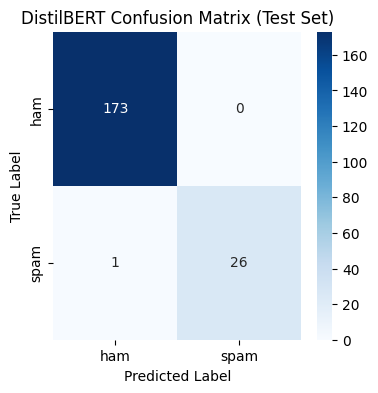

In [22]:
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["ham", "spam"],
    yticklabels=["ham", "spam"]
)
plt.title("DistilBERT Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Section 13 — Model Comparison and Conclusion

This section compares the baseline TF-IDF + Logistic Regression model with the
fine-tuned DistilBERT model and summarises the key findings of the study.

In [23]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["TF-IDF + Logistic Regression", "DistilBERT (Fine-Tuned)"],
    "Accuracy": [baseline_accuracy, bert_accuracy],
    "Precision (Spam)": [baseline_precision, bert_precision],
    "Recall (Spam)": [baseline_recall, bert_recall],
    "F1-score (Spam)": [baseline_f1, bert_f1]
})

comparison_df

,Model,Accuracy,Precision (Spam),Recall (Spam),F1-score (Spam)
0,TF-IDF + Logistic Regression,0.985,0.928571,0.962963,0.945455
1,DistilBERT (Fine-Tuned),0.995,1.000000,0.962963,0.981132


# Results

In [24]:
import torch

id_to_label = {0: "ham", 1: "spam"}

def predict_sms(text, model, tokenizer, max_length=128):
    model.eval()

    encoding = tokenizer(
        text.lower(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        pred_id = int(probs.argmax())

    return {
        "text": text,
        "prediction": id_to_label[pred_id],
        "confidence": float(probs[pred_id]),
        "prob_ham": float(probs[0]),
        "prob_spam": float(probs[1])
    }

In [25]:
sample_texts = [
    "Congratulations! You have won a £1000 Tesco gift card. Click here to claim now!",
    "Hi Indhu, are you coming to class today?",
    "URGENT! Your account has been suspended. Verify your details immediately.",
    "Can you call me when you're free? Need to talk about tomorrow.",
    "FREE entry in 2 a weekly competition to win FA Cup final tickets. Text WIN to 80086 now!"
]

for t in sample_texts:
    result = predict_sms(t, model, tokenizer, max_length=MAX_LENGTH)
    print("-" * 80)
    print("Text:", result["text"])
    print("Prediction:", result["prediction"])
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Prob(ham): {result['prob_ham']:.4f} | Prob(spam): {result['prob_spam']:.4f}")

--------------------------------------------------------------------------------
Text: Congratulations! You have won a £1000 Tesco gift card. Click here to claim now!
Prediction: spam
Confidence: 0.9666
Prob(ham): 0.0334 | Prob(spam): 0.9666
--------------------------------------------------------------------------------
Text: Hi Indhu, are you coming to class today?
Prediction: ham
Confidence: 0.9967
Prob(ham): 0.9967 | Prob(spam): 0.0033
--------------------------------------------------------------------------------
Text: URGENT! Your account has been suspended. Verify your details immediately.
Prediction: spam
Confidence: 0.6027
Prob(ham): 0.3973 | Prob(spam): 0.6027
--------------------------------------------------------------------------------
Text: Can you call me when you're free? Need to talk about tomorrow.
Prediction: ham
Confidence: 0.9939
Prob(ham): 0.9939 | Prob(spam): 0.0061
--------------------------------------------------------------------------------
Text: FREE entr